In [1]:
import pandas as pd
import numpy as np
import pm4py
import os
from sklearn.neighbors import KernelDensity
import random
from collections import Counter
import copy
import warnings
warnings.filterwarnings("ignore")

In [2]:
# info of train_data
if_csv = False #
import_file = 'bac_cut.xes' #
id_column = 'REQUEST_ID'
act_column = 'concept:name'
time_column = 'time:timestamp'
resource_column = 'user'
state_column = 'lifecycle:transition'

dirStr, ext = os.path.splitext(import_file)
file_name = dirStr.split("\\")[-1]


data = pm4py.read.read_xes(import_file)

df = copy.deepcopy(pd.DataFrame(data,columns=[id_column, act_column, time_column, resource_column, state_column]))

parsing log, completed traces ::   0%|          | 0/200 [00:00<?, ?it/s]

In [3]:
df['waiting_time'] = None
df['process_time'] = None
df['last_complete_event'] = None
df['preceding_evts'] = None
df['paired_event'] = None
df['next'] = None
df['index'] = df.index
for key, group in df.groupby(id_column):
    flag = 0
    i = list(group.index)[0]
    preceding_evt = []
    not_complete_evt_idx = []
    j = 0
    df['waiting_time'].loc[i] = 0
    not_complete_evt_idx.append(i)
    i+=1
    while j<len(group)-1:
        j+=1
        cur_act = df.loc[i]
        if cur_act[state_column] == 'complete':
            flag = 0
            preceding_evt.append(cur_act.name)
            last_complete_evt_idx = i
            
            for each_idx in not_complete_evt_idx:
                to_pair = df.loc[each_idx]
                if (cur_act[act_column] == to_pair[act_column]) \
                and (cur_act[resource_column] == to_pair[resource_column]):
                    df['paired_event'].loc[i] = each_idx
                    not_complete_evt_idx.remove(each_idx)
                    df['process_time'].loc[i] = (df[time_column].loc[i] - df[time_column].loc[each_idx]).total_seconds()
                    df['last_complete_event'].loc[i] = df['last_complete_event'].loc[each_idx]
                    break
            
        else:
            if flag == 1:
                df['preceding_evts'].loc[i] = df['preceding_evts'].loc[i-1]
            else:
                df['preceding_evts'].loc[i] = preceding_evt#tuple(sorted, reverse=False))
            for each in df['preceding_evts'].loc[i]:
                if df['next'].loc[each] == None:
                    df['next'].loc[each] = [i]
                else:
                    temp = df['next'].loc[each]
                    temp.append(i)
                    df['next'].loc[each] = temp
            flag = 1
            preceding_evt = []
            not_complete_evt_idx.append(i)
            
            df['last_complete_event'].loc[i] = last_complete_evt_idx
            df['waiting_time'].loc[i] = (df[time_column].loc[i] - df[time_column].loc[last_complete_evt_idx]).total_seconds()
        i+=1

In [4]:
def fillna_parallel_data(bb):
    i = bb.index[0]
    j = 0 
    while j < len(bb):
        if bb[state_column].loc[i] == 'complete':
            paired = int(bb['paired_event'].loc[i])
            bb['process_time'].loc[paired] = bb['process_time'].loc[i] 
            bb['paired_event'].loc[paired] = i
            bb['next'].loc[paired] = bb['next'].loc[i]
            bb['waiting_time'].loc[i] = bb['waiting_time'].loc[paired] 
            bb['preceding_evts'].loc[i] = bb['preceding_evts'].loc[paired]
            bb['next'].loc[paired] = bb['next'].loc[i] 
        i+=1
        j+=1
fillna_parallel_data(df)


In [80]:
df

,REQUEST_ID,activity,time:timestamp,user,lifecycle:transition,waiting_time,process_time,last_complete_event,preceding_evts,paired_event,next,index
0,20181011389,Request created,2018-04-13 10:32:10+00:00,00456,start,0,58,None,None,1,[2],0
2,20181011389,Evaluating Request (NO registered letter),2018-04-13 10:33:08+00:00,00456,start,0,55,1,[1],3,[4],2
4,20181011389,Service closure Request with network responsib...,2018-04-13 11:20:52+00:00,00456,start,2809,134,3,[3],5,[6],4
6,20181011389,Service closure Request with BO responsibility,2018-04-13 11:23:06+00:00,BOC,start,0,957164,5,[5],7,[8],6
8,20181011389,Network Adjustment Requested,2018-04-24 13:15:50+00:00,00456,start,0,1.88345e+07,7,[7],9,[10],8
...,...,...,...,...,...,...,...,...,...,...,...,...
2694,201812009435,Service closure Request with network responsib...,2019-01-03 09:29:35+00:00,00241,start,260338,67,2693,[2693],2695,[2696],2694
2696,201812009435,Service closure Request with BO responsibility,2019-01-03 09:30:42+00:00,BOC,start,0,616007,2695,[2695],2697,[2698],2696
2698,201812009435,Pending Request for Reservation Closure,2019-01-10 12:37:29+00:00,BOC,start,0,117,2697,[2697],2699,[2700],2698
2700,201812009435,Pending Liquidation Request,2019-01-10 12:39:26+00:00,BOC,start,0,138865,2699,[2699],2701,[2702],2700


In [81]:
df = df[df[state_column]=='start']
df = df.rename(columns = {'concept:name':'activity'})
file = df[['activity', 'user', 'waiting_time', 'process_time']]
file

,activity,user,waiting_time,process_time
0,Request created,00456,0,58
2,Evaluating Request (NO registered letter),00456,0,55
4,Service closure Request with network responsib...,00456,2809,134
6,Service closure Request with BO responsibility,BOC,0,957164
8,Network Adjustment Requested,00456,0,1.88345e+07
...,...,...,...,...
2694,Service closure Request with network responsib...,00241,260338,67
2696,Service closure Request with BO responsibility,BOC,0,616007
2698,Pending Request for Reservation Closure,BOC,0,117
2700,Pending Liquidation Request,BOC,0,138865


In [82]:
import math
file['waiting_time'] = file['waiting_time'].map(lambda x: math.log(x+1))
file['process_time'] = file['process_time'].map(lambda x: math.log(x+1))

In [83]:
file.reset_index(drop=True, inplace = True)
file

,activity,user,waiting_time,process_time
0,Request created,00456,0.00000,4.077537
1,Evaluating Request (NO registered letter),00456,0.00000,4.025352
2,Service closure Request with network responsib...,00456,7.94094,4.905275
3,Service closure Request with BO responsibility,BOC,0.00000,13.771731
4,Network Adjustment Requested,00456,0.00000,16.751201
...,...,...,...,...
1347,Service closure Request with network responsib...,00241,12.46974,4.219508
1348,Service closure Request with BO responsibility,BOC,0.00000,13.331015
1349,Pending Request for Reservation Closure,BOC,0.00000,4.770685
1350,Pending Liquidation Request,BOC,0.00000,11.841265


In [84]:
from collections import Counter
from sklearn import preprocessing
new_data = pd.DataFrame()
def get_info(df, new_df, column_name, column_type):
    if column_type == 'categorical':
        df[column_name].fillna(f'NO_{column_name}',inplace=True)
        dict_ = {}
        a = Counter(df[column_name])     
        dict_['name'] = column_name
        dict_['size'] = len(a.keys())
        dict_['type'] = column_type
        enc=preprocessing.LabelEncoder()
        enc=enc.fit(list(a.keys()))#训练LabelEncoder,将电脑，手表，手机编码为0,1,2
        data=enc.transform(df[column_name])#使用训练好的LabelEncoder对原数据进行编码，也叫归一化
        dict_['i2s'] = list(enc.classes_)
        new_df[column_name] = data
        return dict_
    else:
        dict_ = {}
        dict_['max'] = max(df[column_name])
        dict_['min'] = min(df[column_name])
        dict_['name'] = column_name
        dict_['type'] = column_type
        new_df[column_name] = df[column_name]
        return dict_


In [85]:
new_data = pd.DataFrame()
a = [ 'activity','user']
b = ['waiting_time', 'process_time']

json_input = {}
json_input['columns'] = [get_info(file, new_data, each, 'categorical') for each in a]
json_input['columns'].extend([get_info(file, new_data, each, 'continuous') for each in b])
json_input['problem_type'] = 'no'

In [86]:
new_data

,activity,user,waiting_time,process_time
0,10,128,0.00000,4.077537
1,2,128,0.00000,4.025352
2,13,128,7.94094,4.905275
3,12,235,0.00000,13.771731
4,4,128,0.00000,16.751201
...,...,...,...,...
1347,13,72,12.46974,4.219508
1348,12,235,0.00000,13.331015
1349,7,235,0.00000,4.770685
1350,5,235,0.00000,11.841265


In [92]:
for key, group in new_data.groupby('activity'):
    if key == 14:
        print(Counter(group['user']))

In [87]:
import json
with open("test_res_time_cut.json","w") as f:
    json.dump(json_input,f)

# with open('test.json') as json_file:
#     a = json.load(json_file)

train = np.array(new_data.iloc[:1000]).astype('float32')
train.shape

test = np.array(new_data.iloc[1000:]).astype('float32')
test.shape


array_dict = {'train':train, 'test':test}
np.savez('test_res_time_cut.npz', **array_dict)




In [89]:
for key, group in new_data.groupby('activity'):
    if key == 5:
        print(np.mean(group['waiting_time']))

0.0


In [75]:
gen = pd.read_csv(r'C:\Users\19wuj\PycharmProjects\CoDi\time_cut_exp\test_sample_0.csv')
gen.rename(columns={'0':'activity', '1':'waiting_time', '2':'process_time'}, inplace = True)
gen

,activity,waiting_time,process_time
0,10.0,0.000000,5.159444
1,2.0,0.000000,9.311469
2,13.0,3.907302,4.533372
3,12.0,0.000000,12.276110
4,4.0,0.000000,9.897589
...,...,...,...
995,10.0,0.000000,4.504892
996,11.0,0.000000,0.570309
997,10.0,0.000000,7.823408
998,6.0,0.000000,14.041931


In [76]:
for key, group in gen.groupby('activity'):
    if key == 10:
        print(np.mean(group['process_time']))

4.682789611489805


In [78]:
math.exp(4.682789611489805)-1

107.07112892399962

In [79]:
math.exp(4.673244100646778)-1

106.04444270891976

In [93]:
import pandas as pd
import numpy as np
import pm4py
import os
from sklearn.neighbors import KernelDensity
import random
from collections import Counter
import copy
import warnings
warnings.filterwarnings("ignore")

In [117]:
# info of train_data
if_csv = False #
import_file = 'train_bac_cut_time.xes' #
id_column = 'caseid'
act_column = 'concept:name'
time_column = 'time:timestamp'
resource_column = 'user'
state_column = 'lifecycle:transition'

dirStr, ext = os.path.splitext(import_file)
file_name = dirStr.split("\\")[-1]


import_file_test = 'test_bac_cut_time.xes' #

data = pm4py.read.read_xes(import_file)
data_test = pm4py.read.read_xes(import_file_test)

data = pd.concat([data, data_test])
data.reset_index(drop=True, inplace = True)
data
df = copy.deepcopy(pd.DataFrame(data,columns=[id_column, act_column, time_column, resource_column, state_column]))

parsing log, completed traces ::   0%|          | 0/160 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

In [118]:
df

,caseid,concept:name,time:timestamp,user,lifecycle:transition
0,20181011389,Start,2018-04-13 10:32:10+00:00,Start,start
1,20181011389,Start,2018-04-13 10:32:10+00:00,Start,complete
2,20181011389,Request created,2018-04-13 10:32:10+00:00,456,start
3,20181011389,Request created,2018-04-13 10:33:08+00:00,456,complete
4,20181011389,Evaluating Request (NO registered letter),2018-04-13 10:33:08+00:00,456,start
...,...,...,...,...,...
3499,201812007944,Back-Office Adjustment Requested,2018-12-31 09:57:00+00:00,BOC,complete
3500,201812007944,Request completed with account closure,2018-12-31 09:57:00+00:00,BOC,start
3501,201812007944,Request completed with account closure,2018-12-31 09:57:00+00:00,BOC,complete
3502,201812007944,End,2018-12-31 09:57:00+00:00,End,start


In [119]:
df['waiting_time'] = None
df['process_time'] = None
df['last_complete_event'] = None
df['preceding_evts'] = None
df['paired_event'] = None
df['next'] = None
df['index'] = df.index
for key, group in df.groupby(id_column):
    flag = 0
    i = list(group.index)[0]
    preceding_evt = []
    not_complete_evt_idx = []
    j = 0
    df['waiting_time'].loc[i] = 0
    not_complete_evt_idx.append(i)
    i+=1
    while j<len(group)-1:
        j+=1
        cur_act = df.loc[i]
        if cur_act[state_column] == 'complete':
            flag = 0
            preceding_evt.append(cur_act.name)
            last_complete_evt_idx = i
            
            for each_idx in not_complete_evt_idx:
                to_pair = df.loc[each_idx]
                if (cur_act[act_column] == to_pair[act_column]) \
                and (cur_act[resource_column] == to_pair[resource_column]):
                    df['paired_event'].loc[i] = each_idx
                    not_complete_evt_idx.remove(each_idx)
                    df['process_time'].loc[i] = (df[time_column].loc[i] - df[time_column].loc[each_idx]).total_seconds()
                    df['last_complete_event'].loc[i] = df['last_complete_event'].loc[each_idx]
                    break
            
        else:
            if flag == 1:
                df['preceding_evts'].loc[i] = df['preceding_evts'].loc[i-1]
            else:
                df['preceding_evts'].loc[i] = preceding_evt#tuple(sorted, reverse=False))
            for each in df['preceding_evts'].loc[i]:
                if df['next'].loc[each] == None:
                    df['next'].loc[each] = [i]
                else:
                    temp = df['next'].loc[each]
                    temp.append(i)
                    df['next'].loc[each] = temp
            flag = 1
            preceding_evt = []
            not_complete_evt_idx.append(i)
            
            df['last_complete_event'].loc[i] = last_complete_evt_idx
            df['waiting_time'].loc[i] = (df[time_column].loc[i] - df[time_column].loc[last_complete_evt_idx]).total_seconds()
        i+=1

In [120]:
def fillna_parallel_data(bb):
    i = bb.index[0]
    j = 0 
    while j < len(bb):
        if bb[state_column].loc[i] == 'complete':
            paired = int(bb['paired_event'].loc[i])
            bb['process_time'].loc[paired] = bb['process_time'].loc[i] 
            bb['paired_event'].loc[paired] = i
            bb['next'].loc[paired] = bb['next'].loc[i]
            bb['waiting_time'].loc[i] = bb['waiting_time'].loc[paired] 
            bb['preceding_evts'].loc[i] = bb['preceding_evts'].loc[paired]
            bb['next'].loc[paired] = bb['next'].loc[i] 
        i+=1
        j+=1
fillna_parallel_data(df)


In [121]:
df = df[df[state_column]=='start']
df = df.rename(columns = {'concept:name':'activity'})
df.reset_index(drop=True, inplace = True)
# df.to_csv('train_bac_cut_time.csv', index=False)

In [122]:
file = df[['activity', 'waiting_time', 'process_time']]
file

,activity,waiting_time,process_time
0,Start,0,0
1,Request created,0,58
2,Evaluating Request (NO registered letter),0,55
3,Service closure Request with network responsib...,2809,134
4,Service closure Request with BO responsibility,0,957164
...,...,...,...
1747,Pending Request for Reservation Closure,0,191
1748,Pending Liquidation Request,0,292725
1749,Back-Office Adjustment Requested,0,541968
1750,Request completed with account closure,0,0


In [123]:
import math
file['waiting_time'] = file['waiting_time'].map(lambda x: math.log(x+1))
file['process_time'] = file['process_time'].map(lambda x: math.log(x+1))

In [124]:
from collections import Counter
from sklearn import preprocessing
new_data = pd.DataFrame()
def get_info(df, new_df, column_name, column_type):
    if column_type == 'categorical':
        df[column_name].fillna(f'NO_{column_name}',inplace=True)
        dict_ = {}
        a = Counter(df[column_name])     
        dict_['name'] = column_name
        dict_['size'] = len(a.keys())
        dict_['type'] = column_type
        enc=preprocessing.LabelEncoder()
        enc=enc.fit(list(a.keys()))#训练LabelEncoder,将电脑，手表，手机编码为0,1,2
        data=enc.transform(df[column_name])#使用训练好的LabelEncoder对原数据进行编码，也叫归一化
        dict_['i2s'] = list(enc.classes_)
        new_df[column_name] = data
        return dict_
    else:
        dict_ = {}
        dict_['max'] = max(df[column_name])
        dict_['min'] = min(df[column_name])
        dict_['name'] = column_name
        dict_['type'] = column_type
        new_df[column_name] = df[column_name]
        return dict_


In [125]:
new_data = pd.DataFrame()
a = [ 'activity']
b = ['waiting_time', 'process_time']

json_input = {}
json_input['columns'] = [get_info(file, new_data, each, 'categorical') for each in a]
json_input['columns'].extend([get_info(file, new_data, each, 'continuous') for each in b])
json_input['problem_type'] = 'no'

In [129]:
new_data.iloc[:1397]
new_data.iloc[1397:]

,activity,waiting_time,process_time
1397,15,0.000000,0.000000
1398,11,0.000000,8.428581
1399,3,0.000000,16.673872
1400,14,3.713572,4.174387
1401,13,0.000000,12.554301
...,...,...,...
1747,8,0.000000,5.257495
1748,6,0.000000,12.586992
1749,1,0.000000,13.202964
1750,10,0.000000,0.000000


In [130]:
import json
with open("train_bac_act_time.json","w") as f:
    json.dump(json_input,f)

# with open('test.json') as json_file:
#     a = json.load(json_file)

train = np.array(new_data.iloc[:1397]).astype('float32')
train.shape

test = np.array(new_data.iloc[1397:]).astype('float32')
test.shape


array_dict = {'train':train, 'test':test}
np.savez('train_bac_act_time.npz', **array_dict)




In [144]:
gen = pd.read_csv('new_technique_train_bac_cut_time.csv')
gen_act = gen['act']
gen_act = gen_act.map(lambda x:json_input['columns'][0]['i2s'].index(x))
gen_act = np.array(gen_act).astype('float32')
gen_act

array_dict = {'gen':gen_act}
np.savez('gen_bac_act_time.npz', **array_dict)

In [217]:
gen

,caseid,act,index,last,next,if_para,start_timestamp,end_timestamp,resource,pro,wait
Unnamed: 0,,,,,,,,,,,
1,1,Start,1,None,2,0,NaN,NaN,Start,0,0
2,1,Request created,2,1,3,0,NaN,NaN,Request created,24,0
3,1,Pending Request for Network Information,3,2,4,0,NaN,NaN,Pending Request for Network Information,93865,0
4,1,Pending Request for Reservation Closure,4,3,5,0,NaN,NaN,Pending Request for Reservation Closure,63,0
5,1,Pending Liquidation Request,5,4,6,0,NaN,NaN,Pending Liquidation Request,172030,0
...,...,...,...,...,...,...,...,...,...,...,...
426,40,Pending Request for Reservation Closure,426,425,427,0,NaN,NaN,Pending Request for Reservation Closure,65,0
427,40,Pending Liquidation Request,427,426,428,0,NaN,NaN,Pending Liquidation Request,117429,0
428,40,Pending Request for acquittance of heirs,428,427,429,0,NaN,NaN,Pending Request for acquittance of heirs,250503,0


In [244]:
gen_diffu_time = pd.read_csv(r'C:\Users\19wuj\PycharmProjects\CoDi\train_bac_act_time_exp\test_sample_0.csv')
gen_diffu_time = gen_diffu_time.rename(columns = {'0':'activity', '1':'waiting_time', '2':'process_time'})
gen_diffu_time['wait'] = gen_diffu_time['waiting_time'].map(lambda x: round(math.exp(x)-1))
gen_diffu_time['pro'] = gen_diffu_time['process_time'].map(lambda x: round(math.exp(x)-1))
gen_diffu_time

,activity,waiting_time,process_time,wait,pro
0,15.0,0.00000,0.037638,0,0
1,11.0,0.00000,3.583011,0,35
2,7.0,0.00000,11.264589,0,78009
3,8.0,0.00000,4.734630,0,113
4,6.0,0.00000,11.505979,0,99307
...,...,...,...,...,...
347,8.0,0.00000,5.063885,0,157
348,6.0,0.19164,11.934934,0,152501
349,9.0,0.00000,5.105574,0,164
350,10.0,0.00000,0.003629,0,0


In [245]:
gen = pd.read_csv('new_technique_train_bac_cut_time.csv')
gen['pro'] = gen_diffu_time['pro']
gen['wait'] = gen_diffu_time['wait']
gen = gen.set_index('Unnamed: 0')
gen['last'] = gen['last'].map(lambda x: int(x) if x!='None' else x)
gen['next'] = gen['next'].map(lambda x: int(x) if x!='None' else x)
gen['last'] = gen['last'].map(lambda x: [x])
gen['next'] = gen['next'].map(lambda x: [x])
gen

,caseid,act,index,last,next,if_para,start_timestamp,end_timestamp,resource,pro,wait
Unnamed: 0,,,,,,,,,,,
1,1,Start,1,[None],[2],0,NaN,NaN,Start,0,0
2,1,Request created,2,[1],[3],0,NaN,NaN,Request created,35,0
3,1,Pending Request for Network Information,3,[2],[4],0,NaN,NaN,Pending Request for Network Information,78009,0
4,1,Pending Request for Reservation Closure,4,[3],[5],0,NaN,NaN,Pending Request for Reservation Closure,113,0
5,1,Pending Liquidation Request,5,[4],[6],0,NaN,NaN,Pending Liquidation Request,99307,0
...,...,...,...,...,...,...,...,...,...,...,...
426,40,Pending Request for Reservation Closure,426,[425],[427],0,NaN,NaN,Pending Request for Reservation Closure,157,0
427,40,Pending Liquidation Request,427,[426],[428],0,NaN,NaN,Pending Liquidation Request,152501,0
428,40,Pending Request for acquittance of heirs,428,[427],[429],0,NaN,NaN,Pending Request for acquittance of heirs,164,0


In [246]:
# get the start time of each generated trace
ia_df = pd.read_csv(r'C:\Users\19wuj\Desktop\test_0621\cut_bac\20\gen_bac_cut_time_1.csv')
ia_df
ia_list = []
for key, group in ia_df.groupby('caseid'):
    group['start_timestamp'] = group['start_timestamp'].map(lambda x: pd.to_datetime(x, format = '%Y-%m-%d  %H:%M:%S'))
    ia_list.append(min(group['start_timestamp']))
len(ia_list)

40

In [247]:
g = pd.DataFrame()
for key, group in gen.groupby('caseid'):
    group = group.set_index('index')
    for i in range(len(group)):
        cur = group.iloc[i]
        if i == 0:
            group['start_timestamp'].iloc[i] = ia_list[int(key)-1]
            group['end_timestamp'].iloc[i] = group['start_timestamp'].iloc[i] + pd.Timedelta(seconds=0)
        else:
            if len(cur['last']) > 1:
                last_time = max(pd.to_datetime(group['end_timestamp'].loc[list(cur['last'])]))
                group['start_timestamp'].iloc[i] = last_time + pd.Timedelta(seconds=group['wait'].iloc[i])
            else:
                last_time = pd.to_datetime(group['end_timestamp'].loc[cur['last'][0]])
                group['start_timestamp'].iloc[i] = last_time + pd.Timedelta(seconds=group['wait'].iloc[i])
            group['end_timestamp'].iloc[i] = group['start_timestamp'].iloc[i] + pd.Timedelta(seconds=group['pro'].iloc[i])
    g = pd.concat([g, group])
g

,caseid,act,last,next,if_para,start_timestamp,end_timestamp,resource,pro,wait
index,,,,,,,,,,
1,1,Start,[None],[2],0,2018-07-04 13:53:52,2018-07-04 13:53:52,Start,0,0
2,1,Request created,[1],[3],0,2018-07-04 13:53:52,2018-07-04 13:54:27,Request created,35,0
3,1,Pending Request for Network Information,[2],[4],0,2018-07-04 13:54:27,2018-07-05 11:34:36,Pending Request for Network Information,78009,0
4,1,Pending Request for Reservation Closure,[3],[5],0,2018-07-05 11:34:36,2018-07-05 11:36:29,Pending Request for Reservation Closure,113,0
5,1,Pending Liquidation Request,[4],[6],0,2018-07-05 11:36:29,2018-07-06 15:11:36,Pending Liquidation Request,99307,0
...,...,...,...,...,...,...,...,...,...,...
426,40,Pending Request for Reservation Closure,[425],[427],0,2018-07-07 08:36:36,2018-07-07 08:39:13,Pending Request for Reservation Closure,157,0
427,40,Pending Liquidation Request,[426],[428],0,2018-07-07 08:39:13,2018-07-09 03:00:54,Pending Liquidation Request,152501,0
428,40,Pending Request for acquittance of heirs,[427],[429],0,2018-07-09 03:00:54,2018-07-09 03:03:38,Pending Request for acquittance of heirs,164,0


In [248]:
g = g.rename(columns = {'act':'task'})
g['caseid'] = g['caseid'].map(lambda x: 'Case'+str(x))
g = g[['caseid', 'task','start_timestamp', 'end_timestamp', 'resource']]
g

,caseid,task,start_timestamp,end_timestamp,resource
index,,,,,
1,Case1,Start,2018-07-04 13:53:52,2018-07-04 13:53:52,Start
2,Case1,Request created,2018-07-04 13:53:52,2018-07-04 13:54:27,Request created
3,Case1,Pending Request for Network Information,2018-07-04 13:54:27,2018-07-05 11:34:36,Pending Request for Network Information
4,Case1,Pending Request for Reservation Closure,2018-07-05 11:34:36,2018-07-05 11:36:29,Pending Request for Reservation Closure
5,Case1,Pending Liquidation Request,2018-07-05 11:36:29,2018-07-06 15:11:36,Pending Liquidation Request
...,...,...,...,...,...
426,Case40,Pending Request for Reservation Closure,2018-07-07 08:36:36,2018-07-07 08:39:13,Pending Request for Reservation Closure
427,Case40,Pending Liquidation Request,2018-07-07 08:39:13,2018-07-09 03:00:54,Pending Liquidation Request
428,Case40,Pending Request for acquittance of heirs,2018-07-09 03:00:54,2018-07-09 03:03:38,Pending Request for acquittance of heirs


In [249]:
g.to_csv(f'gen_diffu_time_{file_name}.csv', index=False)

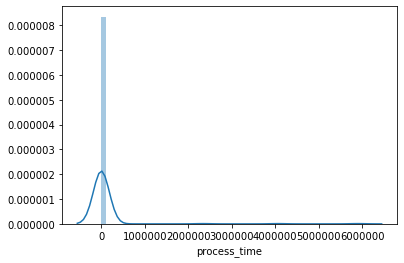

In [284]:
file = df[['activity', 'waiting_time', 'process_time']]
import seaborn as sns

sns.distplot(file[file['activity'] == 'Request created']['process_time'])

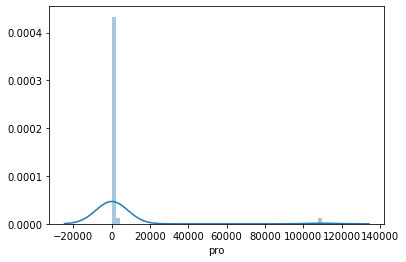

In [285]:
gen_diffu_time = pd.read_csv(r'C:\Users\19wuj\PycharmProjects\CoDi\train_bac_act_time_exp\test_sample_0.csv')
gen_diffu_time = gen_diffu_time.rename(columns = {'0':'activity', '1':'waiting_time', '2':'process_time'})
gen_diffu_time['wait'] = gen_diffu_time['waiting_time'].map(lambda x: round(math.exp(x)-1))
gen_diffu_time['pro'] = gen_diffu_time['process_time'].map(lambda x: round(math.exp(x)-1))
gen_diffu_time
sns.distplot(gen_diffu_time[gen_diffu_time['activity'] == 11.0]['pro'])